In [4]:
import numpy as np
from matplotlib import pyplot as plt

from scipy.sparse import csr_matrix, lil_matrix
from scipy.sparse.csgraph import dijkstra
from scipy.sparse.linalg import norm, eigen

from matplotlib import pyplot as plt
import networkx as nx

from tqdm.auto import tqdm
from scipy.stats import kendalltau, spearmanr, pearsonr

from load_data import *

from fnss.topologies.randmodels import erdos_renyi_topology
import fnss

import re


In [39]:
def mcfp(graph, D, eta_f=1e-1, eta_g=1e-1, eps=1e-3, seed=0, n_iter=1_000, verbose=False):
    rows, cols = graph.nonzero()
    np.random.seed(seed)
    # initialization
    y = csr_matrix((np.ones(rows.shape), (rows, cols)), shape=graph.shape)
    dist, pred = dijkstra(csgraph=y, directed=True, indices=None, return_predecessors=True)
    budget = 0.0
    for s, t, d in D:
        cur_node = t
        while cur_node != s:
            cur_node = pred[s, cur_node]
        budget += d * dist[s, t]
    assert budget > 1.0
    y *= 1.5 / budget
    
    src_to_ids = {node: i for i, node in enumerate(set([el[0] for el in D]))}
    losses = []
    n_g = 0
    for k in tqdm(range(n_iter), leave=False):
        budget = -1.0
        dist, pred = dijkstra(csgraph=y, directed=True, indices=[node for node in src_to_ids],
                              return_predecessors=True)
        grad = lil_matrix(graph.shape) * 0 # sum d_k grad l_k
        for s, t, d in D:
            cur_node = t
            while cur_node != s:
                grad[pred[src_to_ids[s], cur_node], cur_node] += d
                cur_node = pred[src_to_ids[s], cur_node]
            budget += d * dist[src_to_ids[s], t]
        assert norm(grad) > 0

        if budget < -eps:
            y += eta_g * grad / norm(grad) / np.sqrt(k + 1)
            n_g += 1
        else:
            losses.append((y.multiply(graph)).sum())
            y -= eta_f * graph / norm(graph) / np.sqrt(k + 1)

        # clip
        y.data = np.where(y.data < 0, 0, y.data)
        if len(losses) > 1 and abs(losses[-1] - losses[-2]) < eps:
            break
        if k % 100 == 0 and k > 0 and verbose:
            print(min(losses))
                
    return min(losses)
    

### Topology Zoo

In [57]:
path_gml = Path('topology_zoo/Aarnet.gml')
path_gml = Path('topology_zoo/Abilene.gml')


grah_gml = read_graph_topology_zoo(path_gml)
# print(grah_gml.adj)
graph = lil_matrix((len(grah_gml.nodes), len(grah_gml.nodes)))
for src, dst_list in grah_gml.adj.items():
    for dest, desc in dst_list.items():
        graph[src, dest] = desc['bandwidth']
        graph[dest, src] = graph[src, dest]

graph /= graph.todense().max()


In [58]:
np.random.seed(0)
D = [(i, j, np.random.rand() * 0.1) for i in range(graph.shape[0]) \
     for j in range(i + 1, graph.shape[0])]
D[:5]

[(0, 1, 0.05488135039273248),
 (0, 2, 0.07151893663724194),
 (0, 3, 0.06027633760716439),
 (0, 4, 0.05448831829968969),
 (0, 5, 0.042365479933890476)]

In [59]:
mcfp(graph, D, n_iter=1_000, verbose=True)

  0%|          | 0/1000 [00:00<?, ?it/s]

2.514156367761968


2.317901781576169

## Approximation with effective number of neighbours

In [60]:
def enn_approx(graph, gamma):
    W = (graph + graph.T).asfptype()

    e_vals, _ = eigen.eigsh(W, k=W.shape[0] - 1)
    n_w = 1 / (1 - gamma)
    n_w /= np.sum(e_vals ** 2 / (1 - gamma * e_vals ** 2)) / W.shape[0]
    return n_w

enn_approx(graph, 0.01), enn_approx(graph, 0.001)

(0.08018192118079336, 0.09653624637687191)

## Approximation wth Laplace spectral gap

In [61]:
def spectral_gap_approx(graph):
    W = (graph + graph.T).asfptype()
    Deg = lil_matrix(graph.shape)
    degrees = np.asarray(W.sum(-1)).reshape(-1)
    for i, d in enumerate(degrees):
        Deg[i, i] = d
    L = Deg - W
    e_vals, _ = eigen.eigsh(W, k=W.shape[0] - 1)
    l1, l2 = np.sort(e_vals)[-2:]
    return l2 - l1, e_vals.max() / e_vals[e_vals > 0].min()

spectral_gap_approx(graph)

(1.1720986466445629, 5.190808607726877)

In [62]:
# transport flows
results = {
    'Barcelona': {'solution': 0.796, 'enn_1e-2': 0.131, 'enn_1e-3': 0.162, 'spec_gap': 0.971},
    'Winnipeg': {'solution': 0.358, 'enn_1e-2': 0.098, 'enn_1e-3': 0.123, 'spec_gap': 1.347},
    'EMA': {'solution': 0.525, 'enn_1e-2': 0.037, 'enn_1e-3': 0.069, 'spec_gap': 0.4778},
    'Anaheim': {'solution': 0.162, 'enn_1e-2': 0.131, 'enn_1e-3': 0.163, 'spec_gap': 0.542},
    'Berlin-Mitte-Center': {'solution': 0.137, 'enn_1e-2': 0.181, 'enn_1e-3': 0.206, 'spec_gap': 0.332},
    'Berlin-Friedrichshain': {'solution': 0.406, 'enn_1e-2': 0.168, 'enn_1e-3': 0.193, 'spec_gap': 0.079},
    'Berlin-Prenzlauerberg-Center': {'solution': 0.09, 'enn_1e-2': 0.204, 'enn_1e-3': 0.229, 'spec_gap': 0.234},
    'Berlin-Tiergarten': {'solution': 0.411, 'enn_1e-2': 0.189, 'enn_1e-3': 0.212, 'spec_gap': 0.016},
    # 'Hessen': {'solution': 1.115, 'enn': 0, 'spec_gap': 0.227}, # enn is slow
    'Terassa': {'solution': 0.589, 'enn_1e-2': 0.149, 'enn_1e-3': 0.169, 'spec_gap': 0.053},
}

# sndlib
results = {
'newyork': {'solution': 0.999, 'spec_gap': 5.72, 'spec_gap_ratio': 21.93, 'enn_1e-2': 0.124, 'enn_1e-3': 0.036},
'atlanta': {'solution': 0.636, 'spec_gap': 1.16, 'spec_gap_ratio': 3.52, 'enn_1e-2': 0.066, 'enn_1e-3': 0.083},
'france': {'solution': 0.414, 'spec_gap': 3.128, 'spec_gap_ratio': 13.99, 'enn_1e-2': 0.022, 'enn_1e-3': 0.067},
'giul39': {'solution': 0.081, 'spec_gap': 1.545, 'spec_gap_ratio': 14.51, 'enn_1e-2': 0.000, 'enn_1e-3': 0.054},
'india35': {'solution': 0.010, 'spec_gap': 2.528, 'spec_gap_ratio': 68.51, 'enn_1e-2': 0.105, 'enn_1e-3': 0.052},
'norway': {'solution': 0.064, 'spec_gap': 2.373, 'spec_gap_ratio': 17.63, 'enn_1e-2': 0.0284, 'enn_1e-3': 0.06372},
'pdh': {'solution': 2.361, 'spec_gap': 7.39, 'spec_gap_ratio': 8.72, 'enn_1e-2': -0.096, 'enn_1e-3': 0.0358},
'pioro40': {'solution': 0.139, 'spec_gap': 0.533, 'spec_gap_ratio': 20.10, 'enn_1e-2': 0.025, 'enn_1e-3': 0.0538},
'sun': {'solution': 0.46, 'spec_gap': 2.37, 'spec_gap_ratio': 17.63, 'enn_1e-2': 0.028, 'enn_1e-3': 0.064},
'ta1': {'solution': 2.172, 'spec_gap': 3.033, 'spec_gap_ratio': 19.059, 'enn_1e-2': -0.059, 'enn_1e-3': 0.055},
'ta2': {'solution': 1.243, 'spec_gap': 2.176, 'spec_gap_ratio': 46.34, 'enn_1e-2': 0.0296, 'enn_1e-3': 0.0727},
'zib54': {'solution': 2.273, 'spec_gap': 2.733, 'spec_gap_ratio': 45.94, 'enn_1e-2': 0.1486, 'enn_1e-3': 0.082},
}


# topology zoo

results = {
'Aarnet': {'solution': 0.1285, 'spec_gap': 0.8509, 'spec_gap_ratio': 844.65, 'enn_1e-2': 0.047, 'enn_1e-3': 0.1754},
'Abilene': {'solution': 2.3179, 'spec_gap': 1.172, 'spec_gap_ratio': 5.19, 'enn_1e-2': 0.08, 'enn_1e-3': 0.097},
    
}


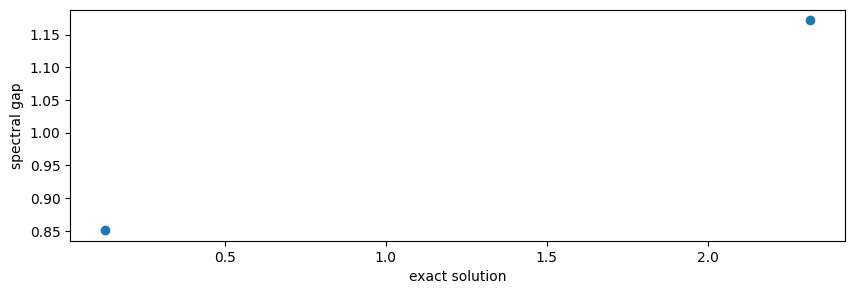

(KendalltauResult(correlation=1.0, pvalue=1.0), (1.0, 1.0))

In [63]:
plt.figure(figsize=(10, 3))
sol = [r['solution'] for r in results.values()]
spec = [r['spec_gap'] for r in results.values()]
plt.scatter(sol, spec)
plt.xlabel('exact solution')
plt.ylabel('spectral gap')

plt.show()
kendalltau(sol, spec), pearsonr(sol, spec)


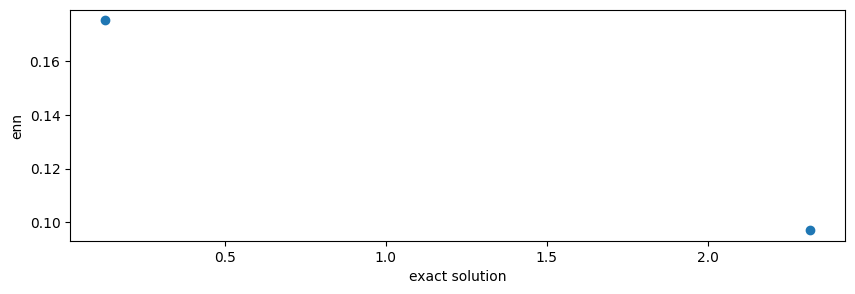

(KendalltauResult(correlation=-1.0, pvalue=1.0), (-1.0, 1.0))

In [64]:
plt.figure(figsize=(10, 3))
sol = [r['solution'] for r in results.values()]
enn = [r['enn_1e-3'] for r in results.values()]
plt.scatter(sol, enn)
plt.xlabel('exact solution')
plt.ylabel('enn')

plt.show()
kendalltau(sol, enn), pearsonr(sol, enn)

## Experiment with synthetic graphs

In [5]:
def gen_graph(r, h, seed=0):
    np.random.seed(seed)
    g = nx.balanced_tree(r, h)
    graph = lil_matrix((len(g.nodes), len(g.nodes)))
    for s, t in g.edges:
        graph[min(s, t), max(s, t)] = 1
    selected_comm = [(0, 1, 1)]
    for i in range(len(g.nodes)):
        for j in range(i + 1, len(g.nodes)):
            if np.random.rand() < 0.1:
                g.add_edge(i, j)
            if np.random.rand() < 0.1 and i != 0 and j != 1:
                selected_comm.append([i, j, 1.0])
    
    # infinite capacity
    return graph * 100, selected_comm


def gen_renyi(n, p, seed=0):
    topology = erdos_renyi_topology(n, p, seed)
    fnss.set_capacities_random_uniform(topology, [1, 2, 3])
    traffic = fnss.traffic.trafficmatrices.static_traffic_matrix(topology, 2, 0.5)
    
    graph = lil_matrix((len(topology.nodes), len(topology.nodes)))
    for (s, t), cap in topology.capacities().items():
        graph[s, t] = cap
        graph[t, s] = cap
        
    D = []
    for (s, t), flow in traffic.flows().items():
        D.append([s, t, flow])
    
    return graph, D
    

In [8]:
graphs_comm = [gen_renyi(n, p, seed) for n in range(7, 15) for p in [0.5, 0.6, 0.7] for seed in range(10)]

In [9]:
mcfp_sol = [mcfp(graph, D) for graph, D in tqdm(graphs_comm)]


  0%|          | 0/240 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

In [19]:
gaps = [spectral_gap_approx(graph)[0] for graph, _ in graphs_comm]
# gaps

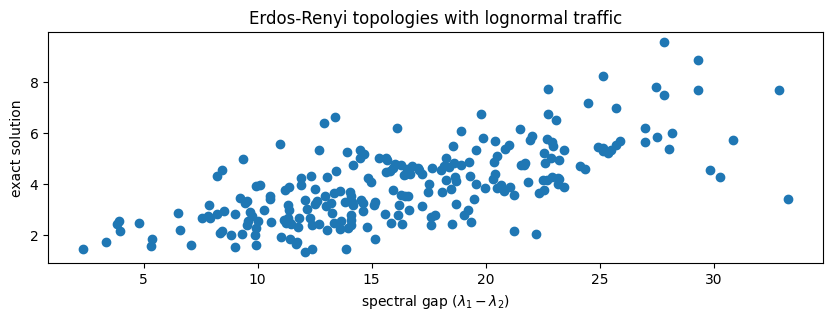

KendalltauResult(correlation=0.4939330543933055, pvalue=4.4366857457879426e-30)

In [30]:
plt.figure(figsize=(10, 3))
plt.scatter(gaps, mcfp_sol)
plt.xlabel(r'spectral gap ($\lambda_1 - \lambda_2$)')
plt.ylabel('exact solution')
plt.title('Erdos-Renyi topologies with lognormal traffic')
plt.show()
kendalltau(gaps, mcfp_sol)

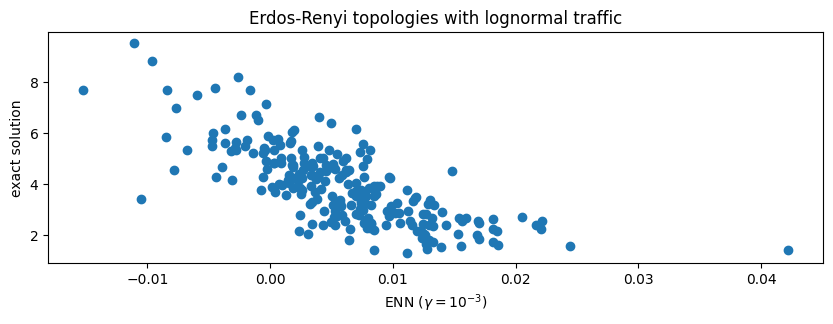

KendalltauResult(correlation=-0.5645746164574617, pvalue=8.877211059171933e-39)

In [31]:
plt.figure(figsize=(10, 3))
n_eff = [enn_approx(graph, 0.001) for graph, D in graphs_comm]
plt.scatter(n_eff, mcfp_sol)
plt.xlabel(r'ENN ($\gamma = 10^{-3}$)')
plt.ylabel('exact solution')
plt.title('Erdos-Renyi topologies with lognormal traffic')
plt.show()
kendalltau(n_eff, mcfp_sol)

In [183]:
! open .